# Boris Bikes

In [8]:
import datetime

import h3 # uber geo package
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import pickle
import os
import folium

import requests as requests
from geopandas import GeoDataFrame, points_from_xy
import movingpandas as mpd
from shapely.geometry import Point
from folium.plugins import TimestampedGeoJson

import re
import contextily as cx
import community
import networkx as nx


from tqdm.auto import tqdm
import pyproj

In [9]:
os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

!echo $PROJ_LIB

/home/fnanni/.cache/pypoetry/virtualenvs/2022-10-06-boris-bikes-EAcWrmnm-py3.9/lib/python3.9/site-packages/pyproj/proj_dir/share/proj


In [10]:
tqdm.pandas()

TODO: this needs doesn't persist in initial notebook run and has to be run again separately and charts redrawn :( - fix

In [11]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

# Introduction


In recent years, London has become a much more cyclist-friendly city, thanks in large part to the Transport for London (TfL) Santander Bike Scheme. The scheme was launched in July 2010 (until 2015 the scheme was sponsored by Barclays Bank) and has since become a popular way for Londoners to get around the city. 

The bicycles, colloquially called "Boris Bikes" after the Mayor of London at the time, are part of a sharing system that allows users to pick them up and drop them off at designated docking stations located around London. The bikes are available 24 hours a day, seven days a week, and are used by Londoners and visitors for a variety of journeys, from commuting to leisure rides. Riders can purchase access to the scheme through a range of payment options, including yearly and monthly memberships as well as a day pass. [The scheme also offers a variety of discounts for students, workers of the National Health Service and users of the Cycle to work scheme](https://tfl.gov.uk/modes/cycling/santander-cycles/register-for-your-own-key).

The scheme has been praised for its convenience and affordability and has become a popular way for Londoners to get around the city. According to some [studies](https://www.bmj.com/content/348/bmj.g425) it has had a positive effect on the health of its users by increasing physical activity within the capital. As reported by TfL in mid 2022 more than 111.2 million journeys had been made using the cycles, with [the record for cycle hires](https://tfl.gov.uk/info-for/media/press-releases/2015/july/london-celebrates-five-successful-years-of-the-mayor-s-flagship-cycle-hire-sche) in a single day being 73,000. In October 2022, TfL introduced new e-bikes to the scheme, the [first docked e-bikes in London](https://tfl.gov.uk/info-for/media/press-releases/2022/october/docked-e-bikes-now-available-for-hire-as-part-of-london-s-record-breaking-santander-cycles-scheme).

In addition to this, the cycling infrastructure has played an essential role in London, as well as in many other cities, during the pandemic. With many people avoiding public transport and opting to cycle instead, the Boris bikes were used by many commuters on their journeys.

For these reasons, in this Turing Data Story we have decided to study the dataset provided by TfL on bike journeys. It is an opportunity to analyse how the scheme and its use has changed over time and how it has affected the daily lives of Londoners.

[TODO Add outline/table of contents, with links to the various sections?]

# Data description 

TfL provides an [open dataset](https://cycling.data.tfl.gov.uk/) containing all bike journeys since the launch of the scheme in July 2010. The dataset contains information about each journey such as start and end stations, start and end dates and times, and the duration of the journey. For this story we are using all available data from the start of the scheme to January 2022.

An example of the format of the data provided by TFL is the following:

| Rental Id	 |Duration |	Bike Id|	End Date|	EndStation Id|	EndStation Name|	Start Date|	StartStation Id	|Start Station Name|
|--------  | -------- | -------- |-------- |-------- |-------- |-------- |-------- |-------- |
| 85323786 | 180	|6711 | 26/03/2019 14:25  |400 | George Street, Marylebone  |26/03/2019 14:22 |6|Broadcasting House, Marylebone|
| 85290142 | 300| 7125 |25/03/2019 13:37 |624 |Courland Grove, Wandsworth Road |25/03/2019 13:32 |772 |Binfield Road, Stockwell |



# Data processing and cleaning

The data covers a wide time range, and the format has seen several small changes in that period. Consequently having a single table with all the journey data requires a bit of cleaning, harmonising, and general data-massaging. Some examples of the kinds of things one needs to deal with are
* Data files are provided at the weekly level and need to be downloaded programatically from the TfL web page,
* Most of the data comes in CSV files, but some time periods are in Excel spreadsheets,
* Station name (string) to station ID (integer) mappings are many-to-many: The same station often has slightly differently spelled names in different files, sometimes the same station has gone by several IDs, and sometimes the same ID has been used for entirely different stations at different times.
* Station IDs are integers, except for one (there's always one isn't there?) that is a string,
* Some rows have missing data,
* Columns in CSV files have changed names a few times,

Dealing with all this is a boring affair and can deviate from the purpose of this data story, and therefore we have decided to do the cleaning elsewere. However, if you enjoy boredom, you can find our data-cleaning script [here](https://github.com/alan-turing-institute/pfeffel/blob/main/src/clean_data.py).

In the end, we have around 100M bicycle journeys of cleaned data (we had to drop a neglibly small number of rows that were missing/malformated beyond repair), all in one pandas DataFrame, that is, thankfully, at around 7 gigabytes just small enough to handle in memory on a modern laptop.

In addition to bike journeys, we also make use of another data set the TfL provides, that has coordinates for the locations of all stations.

We have uploaded all the necesary datasets for this story onto Zenodo[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7551619.svg)](https://doi.org/10.5281/zenodo.7551619). The below cell downloads the cleaned data into a subfolder called `data`.

In [12]:
!mkdir data

!wget https://zenodo.org/record/7509993/files/BorisBikes_journeys_cleaned_data.pickle -P data/
!wget https://zenodo.org/record/7509993/files/BorisBikes_station_names.pickle -P data/
!wget https://zenodo.org/record/7509993/files/BorisBikes_stations_coordinates.json -P data/

mkdir: cannot create directory ‘data’: File exists
--2023-03-15 13:43:13--  https://zenodo.org/record/7509993/files/BorisBikes_journeys_cleaned_data.pickle
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7318455024 (6.8G) [application/octet-stream]
Saving to: ‘data/BorisBikes_journeys_cleaned_data.pickle.1’

BorisBikes_journeys 100%[===================>]   6.82G  13.7MB/s    in 14m 40s 

2023-03-15 13:57:54 (7.93 MB/s) - ‘data/BorisBikes_journeys_cleaned_data.pickle.1’ saved [7318455024/7318455024]

--2023-03-15 13:57:54--  https://zenodo.org/record/7509993/files/BorisBikes_station_names.pickle
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55827 (55K) [application/octet-stream]
Saving to: ‘data/BorisBikes_station_names.pickle.

## Load processed data 

Let's load the data into a pandas DataFrames and take a look at it.

In [13]:
# TODO update
RAW = "data/BorisBikes_journeys_cleaned_data.pickle"
LOCATION_REF = "data/BorisBikes_stations_coordinates.json"

In [14]:
station_locations_df = pd.read_json(LOCATION_REF).T
station_locations_df.head()

lat       lon
85  51.500647 -0.078600
86  51.489479 -0.115156
87  51.516468 -0.079684
88  51.518587 -0.132053
89  51.526250 -0.123509

In [15]:
# load raw data
df = pd.read_pickle(RAW)
len(df)

97656969

As mentioned above we have around 100 million rows.

Some trips have bogus dates from before the scheme started, or from the future. We drop those rows from our dataset. We do allow for journeys that have no end date, since there's quite a lot of them, and presumably they could mark bikes that were lost or broke down.

In [16]:
EARLIEST_DATE = datetime.datetime(2010, 1, 1)

In [17]:
%%time
# filter out of range dates
df = df[df["start_date"] > EARLIEST_DATE]
# allow NA for end dates
df = df[(df["end_date"] > EARLIEST_DATE) | df["end_date"].isna()]

# also drop entries where start date before end date
df = df[df["start_date"] < df["end_date"]]

# recalc duration
df["duration"] = df["end_date"]  - df["start_date"] 

CPU times: user 25 s, sys: 9.31 s, total: 34.3 s
Wall time: 34.3 s


TODO Why are we timing the above cell?

We still have the vast majority of our data left after this:

In [18]:
len(df)

97120201

The last journey date observed in our dataset is the following:

In [19]:
max(df['end_date'])

Timestamp('2022-01-04 23:59:00')

# Statistics on bike usage


After some basic cleaning in the sections above we can start looking at some statitics. Let's see how many unique bikes we have in our dataset:

In [20]:
df["bike_id"].nunique()

21149

We assume that every one of those 21 thousand unique bike IDs corresponds to a different physical bike. If a bike has changed its ID or an ID has been reused, we have no way of telling that, and we assume it does not happen.

Now, let's look at the bike with the most trips in our dataset: 

In [21]:
bike_groups = df.groupby("bike_id")

# bike with the most trips
group_counts = bike_groups.count()["filename"] # pick abritrary column (without nulls) to get counts
b_id = group_counts.idxmax()
n_trips = group_counts.loc[b_id]

print(f"""
bike with most trips: {b_id}
did {n_trips} trips
""")


bike with most trips: 8875
did 10034 trips



Trips vary in length, so let's also see what the maximum number of hours a bike has been used is, summing up the durations of all its trips:

In [22]:
# bike with the longest trips
group_sums = bike_groups["duration"].sum()
b_id = group_sums.idxmax()
d_sum = group_sums.loc[b_id]

print(f"""
bike with longest sum duration of trips: {b_id}
total of {d_sum} of time in use
""")


bike with longest sum duration of trips: 2143
total of 215 days 05:46:00 of time in use



TODO Have we checked if the above bike looks to be for real? There could be some anomalous single trip that lasted for 8 months, because someone messed up putting their bike back in or something.
TODO Could we do the below plot with minutes rather than seconds as the unit? More intuitive.

At the macro level we can look at the distribution of the durations of the journeys (here we have decided to exclude outliers representing very long journeys to focus on the bulk of the distribution). 

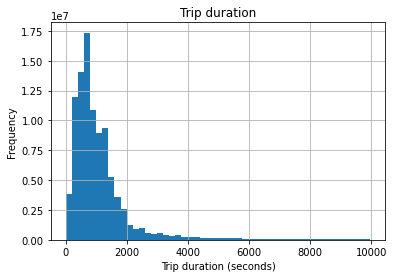

In [23]:

fig, ax = plt.subplots()
ax = df[df["duration"].dt.seconds < 10000]["duration"].dt.seconds.hist(bins=50)
plt.xlabel('Trip duration (seconds)')
plt.ylabel('Frequency')
plt.title('Trip duration')
plt.show()



We can see in the figure above that the bikes are used mostly for short journeys, with the core of the distribution centered around journeys ~15 minutes long, and most of the journeys are less than 30 minutes. 


## Long-lived bikes

We can use this distribution to calculate the average lifetime of a bike. We define as lifetime the time period in which a bike is present (has recorded trips) in our dataset.

To do this, for a given bike we find the earliest start date and the latest end date of the bike available in the dataset. 

In [24]:
trips_per_bike = bike_groups["filename"].count()
bike_start = bike_groups["start_date"].first()
bike_end = bike_groups["end_date"].last()
bike_lifetime = bike_end - bike_start

The distribution of the lifetimes in days is the following

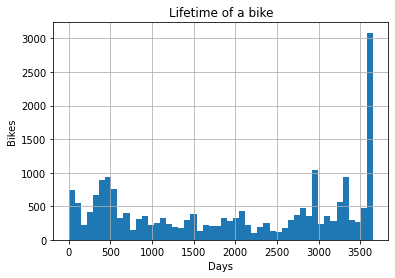

In [25]:
fig, ax = plt.subplots()
ax = bike_lifetime.dt.days.hist(bins=50)
plt.xlabel('Days')
plt.ylabel('Bikes')
plt.title('Lifetime of a bike')
plt.show()

The distribution looks quite flat, with a large peak on around ~3600 days. These are very likely bikes that have been part of the scheme from the begining.

Now, let's see what the average utilisation of a bike is. By this we mean the total ride duration divided by its total lifetime.

In [26]:
duration_sums = bike_groups["duration"].sum()
bike_utilisation = duration_sums / bike_lifetime

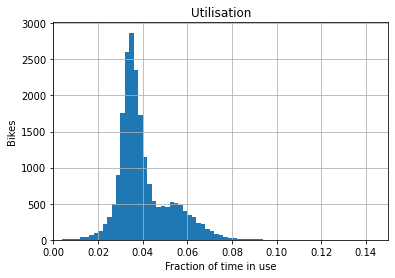

In [27]:
fig, ax = plt.subplots()
ax = bike_utilisation.hist(bins=500)
plt.xlim([0, 0.15])
plt.xlabel('Fraction of time in use')
plt.ylabel('Bikes')
plt.title('Utilisation')
plt.show()

The distribution above shows that during its lifetime an average bike gets used around 45 minutes per day. 

We must note the caveat that the lifetime definition does not consider the time bikes are in maintenance or not in service for any given reason. As a consequence this utilisation metric may be an underestimate, because it counts any downtime as the bike being available but not in use. 

### Time series of bike usage

The number of bikes and stations has evolved since the begining of the scheme, with more being added every year.
Furthermore, London has changed since 2010 and bike usage might have changed with it. 
Hence we'll take a look at the number of bikes and stations available and bike utilisation as functions of time. 

Our utilisation measure here will be slightly different to previous figure. Previously we looked at the utilisation at the bike level and averaged this. Now, we're looking at sum of use over the entire fleet and dividing this by the max possible usage per month (all bikes in use 24/7).

Let's start by creating a monthly index for the time series:


In [28]:
# don't want to incude first and last months as may be incompelte, use in filter later
incomplete_months = df["start_date"].iloc[[0, -1]].dt.to_period("M")
# create a complete monthly index that covers ALL months in period 
complete_monthly_index = pd.date_range(start=df["start_date"].iloc[0], end=df["end_date"].iloc[-1], freq="M").to_period("M")
# remove incomplete months
complete_monthly_index = complete_monthly_index.delete(complete_monthly_index.isin(incomplete_months))

Next we create a function that counts how many bikes or stations are in use in a given month. 


In [29]:
def calc_alive_per_month(starts: pd.Series, ends: pd.Series, incomplete_months: pd.Series, complete_monthly_index: pd.PeriodIndex):
    starts_per_month = starts.dt.to_period("M").value_counts()
    ends_per_month = ends.dt.to_period("M").value_counts()

    counts_df = complete_monthly_index.to_frame(name="foo").join(starts_per_month).join(ends_per_month).sort_index().fillna(0)
    # ending items should only be counted at the start of next month, so shift
    counts_df["end_date"] = counts_df["end_date"].shift(fill_value=0)

    alive_per_month = counts_df["start_date"].cumsum() - counts_df["end_date"].cumsum()
    
    return alive_per_month[~alive_per_month.index.isin(incomplete_months)]

Using the function defined above we create a dataframe of bikes available at the monthly level.


In [30]:
alive_bikes_per_month = calc_alive_per_month(starts=bike_start, ends=bike_end, incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

We are also interested in seeing the total usage of the bikes per month in terms of the sum of the duration of each journey and the total utilisation. 

In [31]:
duration_sums_per_month = df[["duration"]].groupby(df["start_date"].dt.to_period("M"))["duration"].sum()

duration_sums_per_month = duration_sums_per_month.to_frame()
duration_sums_per_month["max_possible_duration"] = duration_sums_per_month.index.map(lambda x: x.end_time - x.start_time)

utilisation_per_month = duration_sums_per_month["duration"] / duration_sums_per_month["max_possible_duration"] / alive_bikes_per_month

# remove incomplete months
utilisation_per_month = utilisation_per_month[~utilisation_per_month.index.isin(incomplete_months)]

Let's also look at how many stations are available in each month. 


In [32]:
station_groups = df.groupby("start_station_id")

# relies on time ordering of df via rental_id
station_start = station_groups["start_date"].first()
station_end = station_groups["end_date"].last()

In [33]:
alive_stations_per_month = calc_alive_per_month(starts=station_start, ends=station_end,
                                                incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

Let's merge our bike usage dataframe with our new station usage data. This results in a monthly indexed dataframe that we can use for visualisation later on:

In [34]:
# forward fill gaps
stats_df = complete_monthly_index.to_frame(name="date")\
    .join(alive_bikes_per_month.rename("alive_bikes"))\
    .join(alive_stations_per_month.rename("alive_stations"))\
    .join(utilisation_per_month.rename("utilisation"))\
    .fillna(method="ffill") 

In [35]:
stats_df.head()

date  alive_bikes  alive_stations  utilisation
2012-02  2012-02        203.0            58.0     1.002468
2012-03  2012-03       2270.0            97.0     0.175476
2012-04  2012-04       2274.0           104.0     0.138298
2012-05  2012-05       2424.0           106.0     0.184298
2012-06  2012-06       2464.0           106.0     0.171878

Let's look at our time series from March 2012.

Text(0.5, 0, 'Years')

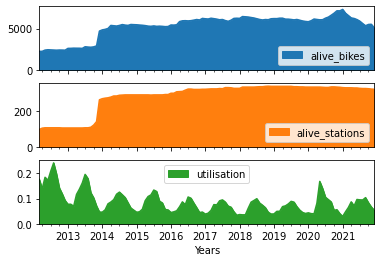

In [36]:
stats_df[1:].plot.area(subplots=True)
plt.xlabel('Years')


TODO What's the unit for utilisation?

We can see clearly the expansion of the scheme in 2012 where new stations were added to [include East London](https://www.theguardian.com/uk/2011/feb/01/bike-hire-scheme-east-london-spring-2012). Another prominent feature is the annual periodicity, where bike utilisation is, unsurprisingly, higher in the summer. Also, the effect of the pandemic in 2020 is evident in the spike in utilisation which seems to have slowly decreased after the excitement of the first couple of years of the scheme. 

# Looking at the behaviour of individual bikes

For the next section of the story we are interested in looking at the pattern of movements of bikes. For this we want to follow the different journeys a bike can take during a time period. For this we need to define a new concept which we call chain. A chain is a sequence of trips for a given bike, where the start location matches the previous end location.

Creating chains for all avalaible bikes in this dataset can be time consuming and we are only interested in a few examples. We will get the chains a subset only: let's look at bikes with the longest lifetimes.

Let's get the top ten longest living bikes in our dataset.

In [37]:
top_ten_lived_bike_ids = bike_lifetime.sort_values()[-10:].index.values

In [38]:
top_ten_bike_subset = df[df["bike_id"].isin(top_ten_lived_bike_ids)].copy()

Let's create a function that for a given bike created a chain id for each secuence journeys. The chain id changes once the starting station of a journey is not the same as the end station from the previous one.


In [39]:
def add_chains(bike_id: int, bike_group: pd.DataFrame, df: pd.DataFrame) -> None:
    """ note: adds to dataframe as side effect """

    # note fillna for end station to allow for comparison to NA
    breaks = bike_group[bike_group["start_station_id"] != bike_group.shift()["end_station_id"].fillna(-1)]
    break_indices = breaks.index.values

    chains = list()
    for i, (start, end) in enumerate(zip([None, *break_indices], [*break_indices, None])):
        chain = bike_group.loc[start:end]
        chain_id = f"{bike_id}_{i}"
        chains.append(pd.Series(chain_id, index=chain.index))
    return pd.concat(chains)

Using the function defined above, lets get the chains for the top ten longest lived bikes.


In [40]:
chains = list()
for k, g in tqdm(top_ten_bike_subset.groupby("bike_id")):
    g = bike_groups.get_group(k)
    chains.append(add_chains(bike_id=k, bike_group=g, df=df))

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
top_ten_bike_subset = top_ten_bike_subset.join(pd.concat(chains).rename("chain_id"))

# A day on the life of a bike


Now that we have "chains" associated to our long lived bikes we can use them to follow them around on a given time period. We are interested to how they move around the city. 


There is still some missingness in our dataset, in the form of stations id not linked to our station dataset. Let's write a simple function to remove journeys where the station information is missing. 


In [42]:
def remove_missing_stations(df, stations):
     
    def check_id(row, stations):
        start_id = str(int(row["start_station_id"]))
        end_id = str(int(row["end_station_id"]))
        if str(start_id) in stations.keys() and str(end_id) in stations.keys():
            return True
        return False
    
    df["check_stations_ids"] = df.apply(
        lambda row: check_id(row, stations), axis=1
    )
    df = df[df.check_stations_ids.eq(True)]
    return df

In [44]:
with open("data/BorisBikes_stations_coordinates.json") as f:
    stations = json.load(f)

data = remove_missing_stations(top_ten_bike_subset,stations)
data.head()

duration  bike_id            end_date  end_station_id  \
rental_id                                                                
9340768   0 days 00:20:00      893 2012-01-04 00:20:00             169   
9340768   0 days 00:20:00      893 2012-01-04 00:20:00             169   
9343209   0 days 00:17:00     3278 2012-01-04 00:23:00             114   
9343209   0 days 00:17:00     3278 2012-01-04 00:23:00             114   
9343534   0 days 00:18:00      540 2012-01-04 00:45:00             211   

                                  end_station_name          start_date  \
rental_id                                                                
9340768               Porchester Place, Paddington 2012-01-04 00:00:00   
9340768               Porchester Place, Paddington 2012-01-04 00:00:00   
9343209    Park Road (Baker Street), Regent's Park 2012-01-04 00:06:00   
9343209    Park Road (Baker Street), Regent's Park 2012-01-04 00:06:00   
9343534               Cadogan Place, Knightsbridge 2012-01-04 00:27:00   

           start_station_id             start_station_name  \
rental_id                                                    
9340768                 224  Queensway, Kensington Gardens   
9340768                 224  Queensway, Kensington Gardens   
9343209                  49         Curzon Street, Mayfair   
9343209                  49         Curzon Street, Mayfair   
9343534                  64      William IV Street, Strand   

                                                    filename chain_id  \
rental_id                                                               
9340768    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...    893_0   
9340768    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...    893_1   
9343209    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...   3278_0   
9343209    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...   3278_1   
9343534    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...    540_0   

           check_stations_ids  
rental_id                      
9340768                  True  
9340768                  True  
9343209                  True  
9343209                  True  
9343534                  True

No we can make this code a bit more formal by building objects that represent Bikes and Trips. A trip is a journey between two stations, the data from TFL only provides a journey starting and final station but we can use https://www.cyclestreets.net/ API to build the most probable route between two points given the duration of that journey.

Our Trip object (containing the journey and route data) is defined as the following:

In [45]:
class Trip:
    def __init__(self, data, bike_id, trip_id, station_data):
        df = data[data.index == trip_id]

        self.init_station = {
            "name": df.start_station_name.values[0],
            "id": df.start_station_id.values[0],
            "latitude": station_data[str(int(df.start_station_id.values[0]))][
                "lat"
            ],
            "longitude": station_data[str(int(df.start_station_id.values[0]))][
                "lon"
            ],
        }
        self.end_station = {
            "name": df.end_station_name.values[0],
            "id": df.end_station_id.values[0],
            "latitude": station_data[str(int(df.end_station_id.values[0]))][
                "lat"
            ],
            "longitude": station_data[str(int(df.end_station_id.values[0]))][
                "lon"
            ],
        }
        self.bike = df.bike_id.values[0]
        self.duration = df.duration.values[0]
        self.date = {
            "start": df.start_date.values[0],
            "end": df.end_date.values[0],
        }
        self.circular = self.init_station == self.end_station
        self.route = {}
        self.bike_id = bike_id
        self.trip_id = trip_id

    def get_route(self, key, route_path= 'routes/'):
        
        if not os.path.exists(route_path):
            os.makedirs(route_path)
            
        route_file_path = (
            route_path
            + str(self.bike_id)
            + "_"
            + str(self.trip_id)
            + ".json"
        )
        if os.path.isfile(route_file_path):
            with open(route_file_path, "r") as fp:
                data = json.load(fp)
                self.route = data
        else:
            if self.circular:
                self.route = {}

            else:
                plans = ["balanced", "fastest", "quietest", "shortest"]

                closest_time = False
                trip_data = {}

                for plan in plans:
                    name = (
                        "https://www.cyclestreets.net/api/journey.json?key="
                        + key
                        + "&itinerarypoints="
                        + str(self.init_station["longitude"])
                        + ","
                        + str(self.init_station["latitude"])
                        + "|"
                        + str(self.end_station["longitude"])
                        + ","
                        + str(self.end_station["latitude"])
                        + "&plan="
                        + plan
                    )
                    data = requests.get(name).json()["marker"][0][
                        "@attributes"
                    ]
                    time = int(data["time"])
                    if closest_time is False:
                        closest_time = abs(time - self.duration)
                        trip_data = data

                    elif abs(self.duration - time) < closest_time:
                        closest_time = abs(time - self.duration)
                        trip_data = data

                self.route = trip_data

            with open(route_file_path, "w") as fp:
                json.dump(self.route, fp)



A Bike object represents a bike identified by its ID. The Bike object has methods that allow you to fetch their "story" which are all the trips recorded in the data and routes obtained from https://www.cyclestreets.net/. 

In order to fetch data from the Cyclestreets API you need to apply for access and obtain a key. For this story we have already downloaded the routes from the API for the bikes in this example.

In [46]:
class Bike:
    def __init__(self, id):
        self.id = id

    def get_chains(self, stations):
        chain_ids = self.bike_rides.chain_id.to_list()
        chains = {}
        for chain_id in chain_ids:
            chain_rides = self.bike_rides[
                self.bike_rides["chain_id"] == chain_id
            ]
            chains[chain_id] = [Trip(chain_rides, self.id, trip_id, stations) for trip_id in chain_rides.index]
            #self.get_trips(chain_rides, stations)
        self.chains = chains

    def get_story(self, dataset, stations,key):
        bike_rides = dataset[dataset["bike_id"] == self.id]
        self.bike_rides = bike_rides
        self.get_chains(stations)
        
        for chain_id, chain in self.chains.items():

            for counter, trip in enumerate(chain):
                trip.get_route(key)
                if trip.route == {}:
                    continue


We can visualise the journeys of a bike on a map using folium and moving pandas.

In [47]:
def get_colours(steps):
    colours = sns.color_palette("mako").as_hex()
    rev_colours = sns.color_palette("mako").as_hex()
    rev_colours.reverse()
    colours = rev_colours + colours
    while len(colours) < steps:
        colours += colours
    return colours


def get_trajectory(bike_id, route_folder = "routes/"):

    chains = [
        filename
        for filename in sorted(os.listdir(route_folder))
        if str(bike_id) + "_" in filename
    ]
    
    times = []
    geometry = []
    colours = []

    many_colurs = get_colours(len(chains))

    for c in range(len(chains)):
        chain = chains[c]
        with open(route_folder + chain) as f:
            d = json.load(f)
        if len(d) > 0:
            geometry += [
                Point([float(y) for y in x.split(",")])
                for x in d["coordinates"].split(" ")
            ]
            if len(times) == 0:
                time_now = datetime.datetime.now()
            else:
                time_now = times[-1]
            times += [
                time_now + datetime.timedelta(seconds=1 * t + 1)
                for t in range(len(d["coordinates"].split(" ")))
            ]
            colours += [
                many_colurs[c] for x in range(len(d["coordinates"].split(" ")))
            ]

    df = pd.DataFrame()

    df["t"] = times
    df["trajectory_id"] = [1 for x in range(len(geometry))]
    df["sequence"] = [x + 1 for x in range(len(geometry))]
    df["colour"] = colours

    gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    gdf = gdf.set_index("t")

    trajs = mpd.TrajectoryCollection(gdf, "trajectory_id")
    trajs = mpd.MinTimeDeltaGeneralizer(trajs).generalize(
        tolerance=datetime.timedelta(seconds=1)
    )
    traj = trajs.trajectories[0]
    return traj

def draw_map(traj):
    features = traj_to_timestamped_geojson(traj)
    # Create base map
    London = [51.506949, -0.122876]
    map = folium.Map(location=London, zoom_start=12, tiles="cartodbpositron")
    TimestampedGeoJson(
        {
            "type": "FeatureCollection",
            "features": features,
        },
        period="PT1S",
        add_last_point=False,
        transition_time=10,
    ).add_to(map)
    return map

def traj_to_timestamped_geojson(trajectory):
    features = []
    df = trajectory.df.copy()
    df["previous_geometry"] = df["geometry"].shift()
    df["time"] = df.index
    df["previous_time"] = df["time"].shift()
    for _, row in df.iloc[1:].iterrows():
        coordinates = [
            [
                row["previous_geometry"].xy[0][0],
                row["previous_geometry"].xy[1][0],
            ],
            [row["geometry"].xy[0][0], row["geometry"].xy[1][0]],
        ]
        times = [row["previous_time"].isoformat(), row["time"].isoformat()]
        features.append(
            {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": coordinates,
                },
                "properties": {
                    "times": times,
                    "style": {
                        "color": row["colour"],
                        "weight": 5,
                    },
                },
            }
        )
    return features


In [49]:
key = open("data/cycle_street_key.txt", "r").read()

In [50]:
bike_id = 893
selected_data = data[(data['start_date']> '2020-03-23') & (data['start_date']< '2020-05-14')]
bike = Bike(id=bike_id)
bike.get_story(selected_data, stations,key)

In [51]:
traj = get_trajectory(bike_id)
map_trajectory = draw_map(traj)

map_trajectory

# Bike mobility patterns

The patterns of mobility observed in this dataset can be abstracted using networks built from trips between stations.

We construct a bidirectional weighted graph/network where the nodes are stations and the weight of an edge from station A to station B is the number of trips taken from A to B.
As we'll see below, this reveals some high-level patterns in different regions and around different stations in London, that vary between seasons, weekdays, and times of the day.

For the network analysis, we use the `networkx` package. We start by writing a function that builds a `networkx` network from a dataframe of trip data. A parameter `trip_count_threshold` is used to exclude edges that have a very small weight, to make the analysis computationally more tractable.

In [53]:
def create_network_from_data(df, trip_count_threshold = 1e-5):
    trip_counts = (
        (
            df[["start_station_id", "end_station_id", "bike_id"]]
            .groupby(["start_station_id", "end_station_id"])
            .count()
        )
        .reset_index()
        .rename(columns={"bike_id": "trip_count"})
    )
    trip_counts = trip_counts.sort_values("trip_count")
    total_num_trips = trip_counts["trip_count"].sum()

    trip_counts = trip_counts[
        trip_counts["trip_count"] >= trip_count_threshold * total_num_trips
    ]

    graph = nx.from_pandas_edgelist(
        trip_counts,
        source="start_station_id",
        target="end_station_id",
        edge_attr="trip_count",
        create_using=nx.DiGraph,
    )

    return graph

As we will see in a moment, our network, like many naturally occurring networks, has so called communities:
these are clusters of nodes that are strongly linked to each other, and less linked to nodes outside the cluster.
In our case this corresponds to groups of bike docking stations that have a lot of traffic amongst each other.

Network theorists have developed many different kinds of algorithms for detecting community structure in networks.
We use the Louvain algorithm, and its implementation in the `python-louvain` package.
The Louvain algorithm chooses the communities by trying to maximise a metric called modularity, that roughly speaking measures how much total weight there is in edges that are internal to communities, compared to weight in edges that cross from one community to another.
It is a greedy and quite fast (O(N log N)) algorithm, that works by hierarchically grouping densely connected nodes together and replacing them with single nodes that represent small communities, grouping those small communities to form bigger communities, etc.
You can find more details on [wikipedia](https://en.wikipedia.org/wiki/Louvain_method) or the documentation of the `python-louvain` [package](https://github.com/taynaud/python-louvain).

Below we write a function that does such community detection. Note that we need to ignore the directionality of our graph, i.e. the distinction between bikes going from station A to station B rather than from B to A. This is a limitation of the Louvain algorithm, but for community-detection purposes the directionality isn't important.


In [54]:
def network_community_detection(graph, edge_weight):
    graph_undirected = nx.Graph()
    undirected_edges = set(sorted(graph.edges))
    for edge in undirected_edges:
        reverse_edge = (edge[1], edge[0])
        trip_count = graph.edges[edge][edge_weight]
        if reverse_edge in graph.edges:
            trip_count += graph.edges[reverse_edge][edge_weight]
        graph_undirected.add_edge(edge[0], edge[1], trip_count=trip_count)

    partition = community.best_partition(graph_undirected, weight=edge_weight)
    df_partition = pd.DataFrame(partition, index=[0]).T.reset_index()
    df_partition.columns = ["id", "partition"]

    return df_partition

Finally a function for visualising these graphs of bike trips and their communities on a map, together with some supporting functions to aid in that job.


In [56]:
# TODO Update the below path
STATION_NAMES_FILE = "data/BorisBikes_station_names.pickle"
STATION_COORDS_FILE = LOCATION_REF

LABEL_STATIONS = [
     "Belgrove Street",
     "Waterloo Station 3",
     "Hyde Park Corner",
     "Aquatic Centre",
     "Bethnal Green Road",
     "Natural History Museum",
     "Kennington Oval",
     "Mudchute DLR",
]


def get_station_name(id):
    with open(STATION_NAMES_FILE, "rb") as f:
        station_allnames = pickle.load(f)

    name = sorted(station_allnames[id])[0]
    name = re.split(";|,|:", name)[0].strip()
    return name


def get_node_info(graph):
    with open(STATION_COORDS_FILE, "r") as f:
        station_latlon = json.load(f)

    nodes = graph.nodes()

    pos = [station_latlon[str(int(node))] for node in nodes]
    pos = [(p["lon"], p["lat"]) for p in pos]

    station_sizes = [i[1] for i in list(graph.degree(weight="trip_count"))]

    labels = [get_station_name(int(node)) for node in nodes]

    nodes_df = pd.DataFrame(
        {"id": list(nodes), "pos": pos, "size": station_sizes, "name": labels}
    )

    return nodes_df


def _scale_range(values, min_scaled, max_scaled):
    values = np.array(values)
    if min_scaled is not None:
        max_value = np.max(values)
        min_value = np.min(values)
        mult_coeff = (max_scaled - min_scaled) / (max_value - min_value)
        add_coeff = (max_value * min_scaled - min_value * max_scaled) / (
            max_value - min_value
        )
        scaled = mult_coeff * values + add_coeff
    else:
        max_value = np.max(values)
        scaled = max_scaled * values / max_value
    return scaled


def _drop_stations_without_location(graph):
    with open(STATION_COORDS_FILE, "r") as f:
        station_latlon = json.load(f)
    nodes = tuple(graph.nodes)
    stations_with_location = tuple(map(int, station_latlon.keys()))
    for n in nodes:
        if n not in stations_with_location:
            print(f"Removing node {n} because of missing location data.")
            graph.remove_node(n)
    return None


def create_network_and_map(
    df,
    label_stations= LABEL_STATIONS,
    allow_self_loops=False,
    arrows=True,
    bg_map_zoom=15,
):
    community_graph = create_network_from_data(df)
    _drop_stations_without_location(community_graph)
    nodes_info = get_node_info(community_graph)
    visualisation_graph = community_graph.copy()
    if not allow_self_loops:
        visualisation_graph.remove_edges_from(
            nx.selfloop_edges(community_graph)
        )
    community_df = network_community_detection(community_graph, "trip_count")
    nodes_info = nodes_info.merge(community_df, on="id")
    nodes_info = nodes_info.sort_values(by="size", ascending=False)
    del community_df

    nodes_info['lon'] = [p[0] for p in nodes_info["pos"]]
    nodes_info['lat'] = [p[1] for p in nodes_info["pos"]]

    nodes_info = GeoDataFrame(nodes_info,geometry=points_from_xy(nodes_info.lon, nodes_info.lat),crs="EPSG:4326")
    # Project to UK national grid
    nodes_info = nodes_info.to_crs("EPSG:27700")
    
    labels = {
        id: name
        for id, name in zip(nodes_info["id"], nodes_info["name"])
        if name in label_stations
    }

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    nodes_info.plot(ax=ax, markersize=1, aspect=None)
    cx.add_basemap(ax, crs=nodes_info.crs, source=cx.providers.Stamen.TonerLite, zoom=bg_map_zoom)
    
    xynps = [np.array([p.x for p in nodes_info["geometry"]]),
        np.array([p.y for p in nodes_info["geometry"]])]
    pos = {
        k: (xynps[0][i], xynps[1][i]) for i, k in enumerate(nodes_info["id"])
    }

    MAX_NODE_SIZE = 300.0
    MIN_NODE_SIZE = 5.0
    
    sizes = _scale_range(nodes_info["size"], MIN_NODE_SIZE, MAX_NODE_SIZE)
    weights = np.array(
        [
            visualisation_graph.edges[e]["trip_count"]
            for e in visualisation_graph.edges
        ]
    )
    
    MAX_EDGE_WIDTH = 3.0
    MIN_EDGE_WIDTH = None  
    
    weights = _scale_range(weights, MIN_EDGE_WIDTH, MAX_EDGE_WIDTH)
    
    MAX_EDGE_ALPHA = 0.9
    MIN_EDGE_ALPHA = None

    edge_alpha = _scale_range(weights, MIN_EDGE_ALPHA, MAX_EDGE_ALPHA)
    
    # Plots
    nx.draw_networkx_nodes(
        visualisation_graph,
        pos=pos,
        nodelist=nodes_info["id"],
        node_color=nodes_info["partition"],
        alpha=1.0,
        node_size=sizes,
        cmap="tab10",
        ax=ax,
    )
    nx.draw_networkx_edges(
        visualisation_graph,
        pos=pos,
        edge_color="#222222",
        width=weights,
        alpha=edge_alpha,
        arrows=arrows,
        ax=ax,
    )
    nx.draw_networkx_labels(
        visualisation_graph,
        pos=pos,
        labels=labels,
        font_size=12,
        ax=ax,
    )
    
    return fig, ax, nodes_info

To make the network analysis computationally manageable, we restrict our attention to data from a single year, in this case 2021.

In [57]:
HARD_START_DATE = datetime.datetime(year=2010, month=1, day=1)

start_date = datetime.datetime(year=2021, month=1, day=1)
end_date = datetime. datetime(year=2022, month=1, day=1)

df = df[
    (df["start_date"] > HARD_START_DATE) & (df["end_date"] > HARD_START_DATE)
]
df_year = df[(df["start_date"] > start_date) & (df["start_date"] < end_date)]

**Plot time!**
Below is the network of bike trips aggregated over weekday mornings only, in 2021.
The colours of the nodes mark the different communities as discovered by the Louvain algorithm.
The lines connecting nodes have arrows indicating the direction of travel and their thickness marks the amount of traffic.

Plotting mornings
Number of communities: 6


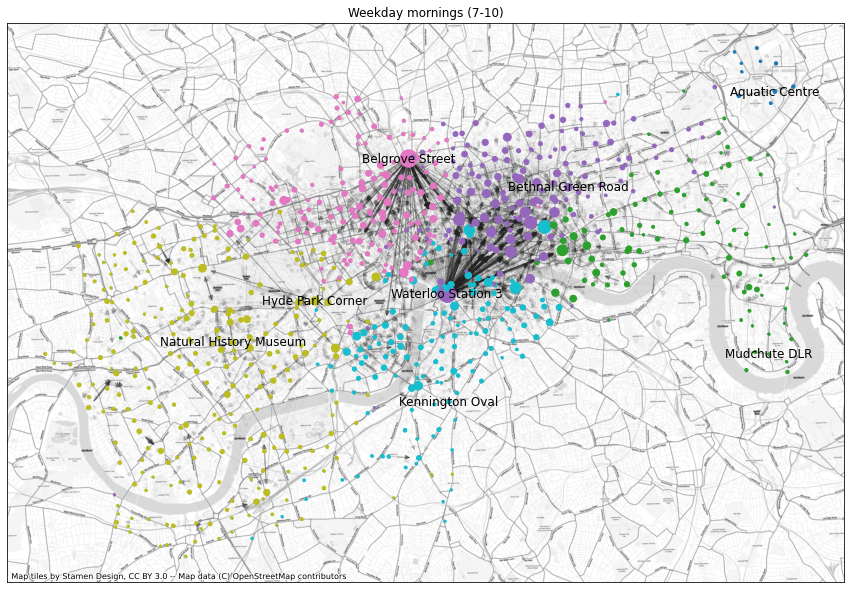

In [ ]:
print("Plotting mornings")
df_year_mornings = df[
    df["start_date"].dt.hour.isin([7, 8, 9, 10])
    & df["start_date"].dt.weekday.isin((0, 1, 2, 3, 4))
]
fig, ax, nodes_info = create_network_and_map(df_year_mornings)
num_communities = len(nodes_info["partition"].unique())
print(f"Number of communities: {num_communities}")
plt.title("Weekday mornings (7-10)")
plt.show()

The two most prominent types of weekday morning traffic are outgoing trips from King's Cross/St. Pancras (station called Belgrove Street marked on the map) and from Waterloo. Commuters presumably come in on trains and cover the last bit to their workplace by a Boris Bike. These two types of traffic form two of the communities found by the Louvain algorithm, with the others being less concentrated communities for East, West, and South London.

Below is a similar graph but for weekday afternoons rather than mornings. The dominant patterns are the reverse of the morning traffic, with people going from their offices to the big train stations. A new feature is a community of traffic around Hyde Park, presumably pleasure rides in the afternoon by people on holiday. 

There are some other shifts in the communities marked by the colours, that we find hard to interpret. There's also some instability and randomness in the Louvain algorithm, where if you run it several times sometimes it divides the smaller communities in slightly different ways. The commuter communities are robust, though.


Plotting afternoons
Number of communities: 12


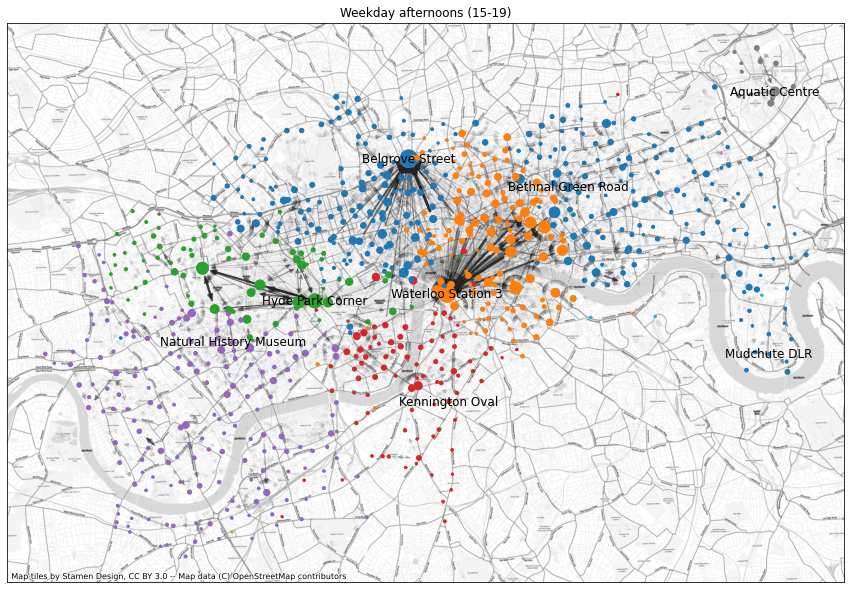

In [58]:
print("Plotting afternoons")
df_year_afternoons = df[
    df["start_date"].dt.hour.isin([15, 16, 17, 18, 19])
    & df["start_date"].dt.weekday.isin((0, 1, 2, 3, 4))
]
fig, ax, nodes_info = create_network_and_map(df_year_afternoons)
num_communities = len(nodes_info["partition"].unique())
print(f"Number of communities: {num_communities}")
plt.title("Weekday afternoons (15-19)")
plt.show()

Below is the same plot but for weekends. Here the most common trips are around Hyde Park and marked by self-loops, where the bike is returned to the same station where it was picked up. We don't know where they were ridden in between, but probably around the park for fun or a picnic. The Olympic Park has a similar loop. The communities again show different regions of London, with people travelling within neighbourhoods, although some of them are somewhat surprising and hard to interpret, with outlier stations way outside the bulk of their communities.


Plotting weekends
Number of communities: 26


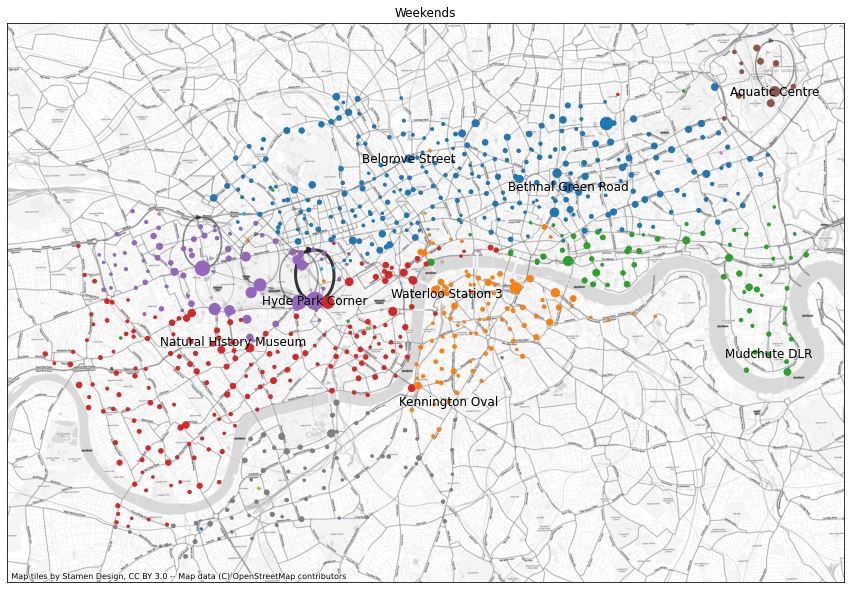

In [59]:
print("Plotting weekends")
df_year_weekends = df[df["start_date"].dt.weekday.isin((5, 6))]
fig, ax, nodes_info = create_network_and_map(
    df_year_weekends,
    allow_self_loops=True,
)
num_communities = len(nodes_info["partition"].unique())
print(f"Number of communities: {num_communities}")
plt.title("Weekends")
plt.show()


Finally, let's see how patterns have changed over time.
Below we create these network plots but this time not for a specific time of day or week, but for specific years: 2013, 2017, 2020, and 2021.

Plotting 2013
Number of communities: 6


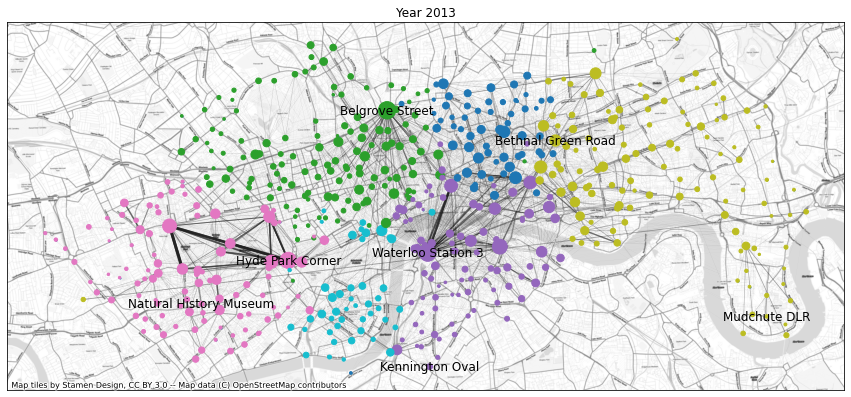

Plotting 2017
Number of communities: 10


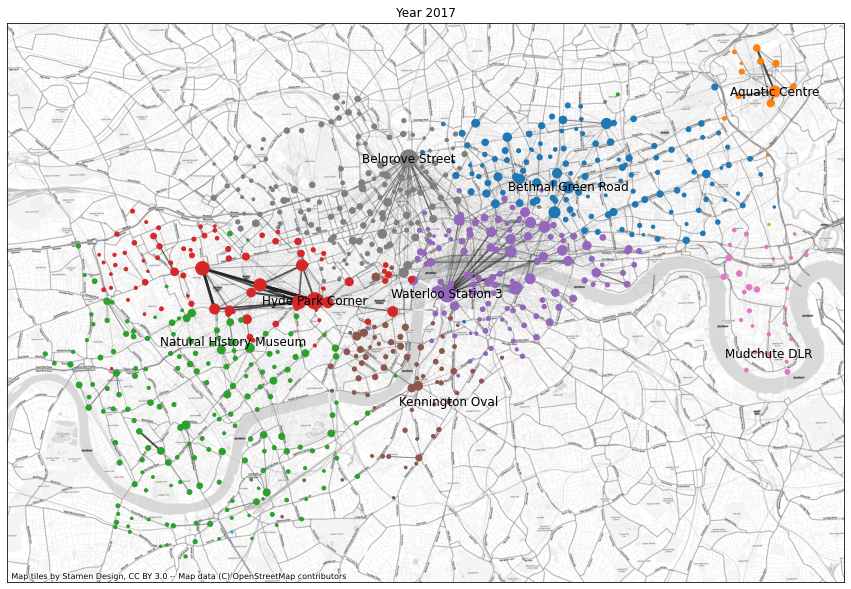

Plotting 2020
Number of communities: 12


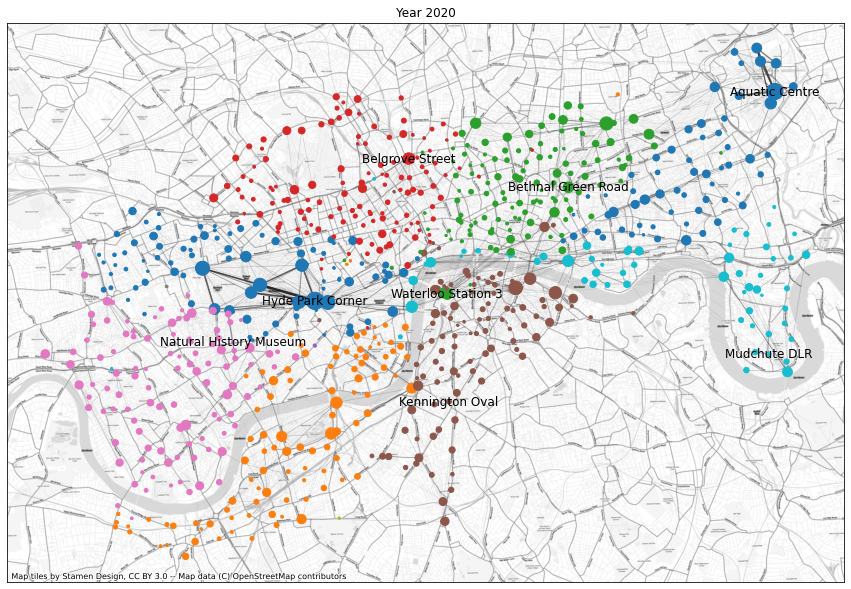

In [61]:
for year in (2013, 2017, 2020):
    print(f"Plotting {year}")
    start_date = datetime.datetime(year=year, month=1, day=1)
    end_date = datetime.datetime(year=year + 1, month=1, day=1)
    df_year = df[
        (df["start_date"] > start_date) & (df["start_date"] < end_date)
    ]
    fig, ax, nodes_info = create_network_and_map(
        df_year,
        allow_self_loops=False,
        arrows=False,
    )
    num_communities = len(nodes_info["partition"].unique())
    print(f"Number of communities: {num_communities}")
    plt.title(f"Year {year}")
    plt.show()


From 2013 to 2017 the big change is the growth of the network of stations.
Especially in the west and southwest, but also around for instance the Olympic Park, the Boris Bike network grows a lot.

From 2017 to 2020 the notable change is the effect of the pandemic: Most of the commuter traffic from e.g. King's Cross and Waterloo has vanished. The dominant traffic patterns that did survive the pandemic were the rides around Hyde Park and the Olympic Park.

Note that we should be careful in reading too much into the coloured communities and how they've changed from year to year. First of all, the colours bear no particular meaning, and the same community may be coloured differently in different plots. Second, the Louvain algorithm for discovering them is stochastic, and many of the smaller communities might arrange themselves differently by simply running the same cell again. The communities with the most traffic remain robust though.

TODO Earlier we talked about the jump in station numbers being due to an expansion in _East_ London. Isn't that in conflict with the above?

# Conclusion

In this Turing data story we aimed to use the TfL bike journey dataset to understand the usage of Boris Bikes and how it has changed, as well as the patterns in how people move around the capital. This story was born out of a 'Hack week' organised by the [Research Engineering Group](https://www.turing.ac.uk/research-engineering) at the Turing, an annual event in which people from the team get to work on projects/datasets they find interesting. 

Our strategy was to extract some general statistics about bike usage over time, followed by trying to characterise the movements of some long-lived bikes, and finally to use network analysis techniques to abstract these movements into high level patterns of behaviour.

Among other things, the analysis very clearly showed how the pandemic changed drasticly the way we move around the city and the strength of the commute links. Furthermore, in the last couple of years a number of other cycling schemes have been introduced, and significant improvements to the cycling infrastructure might have encouraged people to acquire their own bikes, both of which may have contributed to changes in Boris Bike use. A task for a future analysis (from a Turing Data Story reader :-) ) is to include 2022 data and see if this change in behaviour has persisted.